In [ ]:
!pip install skorch
!pip install modAL-python
!pip install scikeras

In [44]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [46]:
def eval_prioritization_strategy(prioritizer):
  train_indices = range(60000)

  test_accuracies = []
  x_train_subset = np.zeros([0, 28, 28])
  y_train_subset = np.empty([0,])

  for i in range(40):
    selected_indices = train_indices[0:500]
    train_indices = train_indices[500:]
    x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...]))
    y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...]))

    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train_subset, y_train_subset, epochs=5, verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_accuracies.append(accuracy)
    print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy))

    predictions = model.predict(x_train[train_indices,...])
    train_indices = prioritizer(train_indices, predictions)

  return test_accuracies


In [47]:
unprioritized_accuracies = eval_prioritization_strategy(lambda indices, pred: indices)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training data size of 500 => accuracy 0.824500
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 1000 => accuracy 0.865200
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 1500 => accuracy 0.896100
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 2000 => accuracy 0.898800
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 2500 => accuracy 0.904500
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 3000 => accuracy 0.914400
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 3500 => accuracy 0.914400
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training data size of 4000 => accuracy 0.918200
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 4500 => accuracy 0.927200
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 5000 => accuracy 0.929800
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Training data size of 5500 => accuracy 0.926500
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [50]:
def least_confidence_prediction_prioritizer(indices, predictions):
  max_logit = list(zip(indices, np.amax(predictions,axis=1)))
  max_logit.sort(key=lambda x: x[1]) # sort in ascending order
  return list(zip(*max_logit))[0]

In [51]:
least_confidence_accuracies = eval_prioritization_strategy(least_confidence_prediction_prioritizer)

Training data size of 500 => accuracy 0.821000
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 1000 => accuracy 0.868300
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training data size of 1500 => accuracy 0.895100
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 2000 => accuracy 0.902300
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 2500 => accuracy 0.927400
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training data size of 3000 => accuracy 0.934500
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 3500 => accuracy 0.939700
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 4000 => accuracy 0.949300
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training data size of 4500 => accuracy 0.956100
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 5000 => accuracy 0.957700
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 5500 => accuracy 0.962800
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [52]:
def entropy_prioritizer(indices, predictions):
  p = predictions * np.log(predictions)
  p = -p.sum(axis=1)
  p = list(zip(indices, p))
  p.sort(reverse=True, key=lambda x : x[1]) # sort in descending order
  return list(zip(*p))[0]

In [53]:
entropy_prioritized_accuracies = eval_prioritization_strategy(entropy_prioritizer)

Training data size of 500 => accuracy 0.818000
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 1000 => accuracy 0.848800
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training data size of 1500 => accuracy 0.885600
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training data size of 2000 => accuracy 0.903900
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 2500 => accuracy 0.905600
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 3000 => accuracy 0.919100
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Training data size of 3500 => accuracy 0.937400
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 4000 => accuracy 0.935400
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 4500 => accuracy 0.949900
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 5000 => accuracy 0.953400
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 5500 => accuracy 0.957400
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [54]:
def margin_prioritizer(indices, predictions):
  p = -np.sort(-predictions) # sort in descending order
  p = p[:,0] - p[:,1]
  p = list(zip(indices, p))
  p.sort(key=lambda x : x[1]) # sort in ascending order
  return list(zip(*p))[0]

In [55]:
margin_prioritized_accuracies = eval_prioritization_strategy(margin_prioritizer)

Training data size of 500 => accuracy 0.819300
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Training data size of 1000 => accuracy 0.895500
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 1500 => accuracy 0.914100
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 2000 => accuracy 0.918200
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 2500 => accuracy 0.934700
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 3000 => accuracy 0.941900
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Training data size of 3500 => accuracy 0.942900
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 4000 => accuracy 0.954500
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 4500 => accuracy 0.955200
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 5000 => accuracy 0.964400
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training data size of 5500 => accuracy 0.965300
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


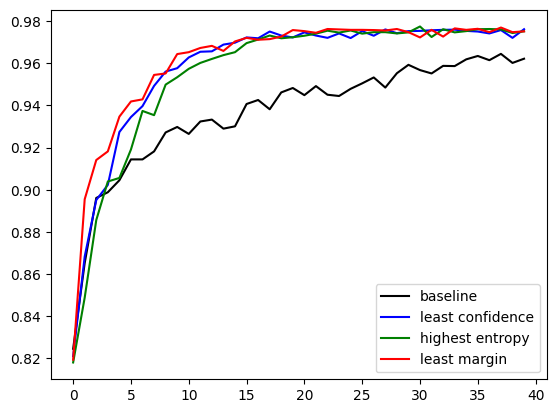

In [56]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.plot(entropy_prioritized_accuracies, 'g', label='highest entropy')
plt.plot(margin_prioritized_accuracies, 'r', label='least margin')
plt.legend()